# Predicting the Popularity of Venues in Downtown Toronto

__TODO__: Add description of the project (it can be the same description as the one in the assignment)

## Import the necessary libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import scipy as sp

from scipy.spatial import distance  # distance matrix computations
from scipy.cluster import hierarchy  # hierarchical clustering

from sklearn.preprocessing import MinMaxScaler  # used to normalize data

import networkx as nx  # plot graphs

import requests  # handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import pylab  # plotting dendograms
import seaborn as sns  # plotting in general
import mplleaflet  # plot map using matplotlib

import folium  # map rendering library

import geopandas  # DataFrame to GeoJSON

import warnings

C:\Users\diego\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get the data from the Toronto Open Data API

In [2]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
payload = {"id": "ae4e10a2-9eaf-4da4-83fb-f3731a30c124"}
response = requests.get(url, params=payload).json()
traffic_df = pd.read_excel(response["result"]['resources'][0]['url'])
traffic_df.head()

,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649418,-79.371446,2017-06-21,15662,13535
1,3,KING ST E,NaN,JARVIS ST,NaN,08/23/1950,43.650461,-79.371924,2016-09-17,12960,7333
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,09/12/1958,43.651534,-79.372360,2016-11-08,17770,7083
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,04/21/1962,43.652718,-79.372824,2015-12-08,19678,4369
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,08/24/1928,43.653704,-79.373238,2016-09-17,14487,3368


Drop and rename some of the columns to make the table easier to work with.

In [3]:
col_rename = {'Side 1 Route': 'Side1',
              '8 Peak Hr Vehicle Volume': 'VehicleVolume',
              '8 Peak Hr Pedestrian Volume': 'PedestrianVolume'}
traffic_df.drop(['TCS #', 'Midblock Route', 'Side 2 Route', 'Activation Date', 'Count Date'], axis=1, inplace=True)
traffic_df.rename(columns=col_rename, inplace=True)

# add column with the intersection name
intersections = traffic_df.loc[:, 'Main'] + ' & ' + traffic_df.loc[:, 'Side1']
traffic_df.loc[:, 'Intersection'] = intersections

traffic_df.head()

,Main,Side1,Latitude,Longitude,VehicleVolume,PedestrianVolume,Intersection
0,JARVIS ST,FRONT ST E,43.649418,-79.371446,15662,13535,JARVIS ST & FRONT ST E
1,KING ST E,JARVIS ST,43.650461,-79.371924,12960,7333,KING ST E & JARVIS ST
2,JARVIS ST,ADELAIDE ST E,43.651534,-79.372360,17770,7083,JARVIS ST & ADELAIDE ST E
3,JARVIS ST,RICHMOND ST E,43.652718,-79.372824,19678,4369,JARVIS ST & RICHMOND ST E
4,JARVIS ST,QUEEN ST E,43.653704,-79.373238,14487,3368,JARVIS ST & QUEEN ST E


In [4]:
count_main = traffic_df['Main'].value_counts().reset_index()
count_main.columns = ['Main', 'Count']

traffic_df = traffic_df.merge(count_main.set_index('Main'), on='Main')
traffic_df.sort_values(by='Count', ascending=False, inplace=True)
traffic_df.reset_index(inplace=True, drop=True)
traffic_df.head()

,Main,Side1,Latitude,Longitude,VehicleVolume,PedestrianVolume,Intersection,Count
0,YONGE ST,QUEEN ST,43.652421,-79.379276,10956,21936,YONGE ST & QUEEN ST,69
1,YONGE ST,LAWRENCE AVE,43.725103,-79.402193,24489,9198,YONGE ST & LAWRENCE AVE,69
2,YONGE ST,EGLINTON AVE,43.706750,-79.398311,23360,20902,YONGE ST & EGLINTON AVE,69
3,YONGE ST,BROADWAY AVE,43.709554,-79.398943,16937,14176,YONGE ST & BROADWAY AVE,69
4,YONGE ST,CASTLEFIELD AVE,43.711855,-79.399437,15456,3080,YONGE ST & CASTLEFIELD AVE,69


The plot below shows a scatter plot of the latitudes and longitudes in the data. This should have roughly the shape of the city, but we see that there is an outlier to the right of -74 degrees of longitude. We are not interested in an intersection that is far away from the core of the city. as such, remove any intersections that have a degree of longitude greater than 74 degrees of longitude, and re-plot to see the corrected data.

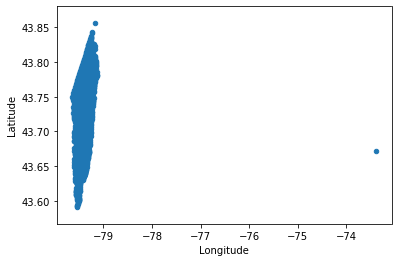

In [5]:
traffic_df.plot(kind='scatter', x='Longitude', y='Latitude')

In [6]:
traffic_df.drop(traffic_df[traffic_df['Longitude'] > -74].index, inplace=True)

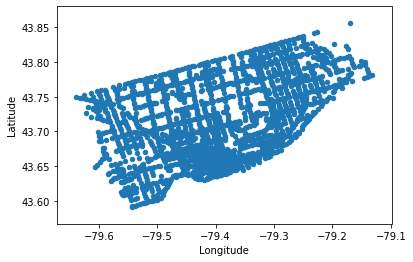

In [7]:
traffic_df.plot(kind='scatter', x='Longitude', y='Latitude')

We see that the plot now resembles the shape of the city.

We want to visualize the busiest intersections in order to choose a region with the highest pedestrian traffic where we will explore venues and hopefully come up with interesting predictions. The following plot shows the intersections in the city, where intersections with a darker colour are busier than those with a lighter colour.

In [14]:
# convert to a GeoDataFrame which will add the geometries required for the choropleth map
gdf = geopandas.GeoDataFrame(traffic_df,
                             geometry=geopandas.points_from_xy(traffic_df.Longitude, traffic_df.Latitude))
gdf.crs = {'init' :'epsg:4326'}  # set the coordinate reference system

# we only want these columns
gdf = gdf.loc[:, ['Intersection', 'PedestrianVolume', 'geometry']]
gdf.head()

,Intersection,PedestrianVolume,geometry
0,YONGE ST & QUEEN ST,21936,POINT (-79.37928 43.65242)
1,YONGE ST & LAWRENCE AVE,9198,POINT (-79.40219 43.72510)
2,YONGE ST & EGLINTON AVE,20902,POINT (-79.39831 43.70675)
3,YONGE ST & BROADWAY AVE,14176,POINT (-79.39894 43.70955)
4,YONGE ST & CASTLEFIELD AVE,3080,POINT (-79.39944 43.71186)


In [13]:
# convert to GeoJSON file in order to use it in the folium.Choropleth function
gdf.to_file('traffic_coordinates.json', driver='GeoJSON')
traffic_geo = r'traffic_coordinates.json'

In [20]:
m = folium.Map(location=[43.6525, -79.381667], zoom_start=10, control_scale=True)

folium.Choropleth(
    gdf).add_to(m)

m

In [ ]:
fig = plt.figure()

# scatter plot of the data
plt.scatter(x=traffic_df['Longitude'].tolist(), y=traffic_df['Latitude'].tolist(), c=traffic_df['PedestrianVolume'].tolist())
plt.xticks(np.round(np.arange(min(traffic_df['Longitude']), max(traffic_df['Longitude']), 0.05), 2))
plt.yticks(np.round(np.arange(min(traffic_df['Latitude']), max(traffic_df['Latitude']), 0.05), 2))

# map
mplleaflet.display()

#plt.show()

In the plot above, we can see that the busiest intersections in terms of pedestrian volume are in the region centred around -79.39 longitude and 43.64 latitude. This makes sense since that is the core of the city. We will be using this region to explore its venues and predict the popularity of new venues.

In the map below you can see the bounding box for the region that we will be looking at. That is, we will only use intersections and venues that are located in this region.

In [ ]:
lat = 43.6525
lng = -79.381667
m = 5000  # metres
a = 6378137  # Radius of earth at equator (m)
e2 = 0.00669437999014  # eccentricity squared
r = np.pi / 180  # convert to radians

# distance of 1 degree latitude
d1 = r * a * (1 - e2) / (1 - e2 * np.sin(lat * r) ** 2) ** (3 / 2)

# distance of 1 degree longitude
d2 = r * a * np.cos(lat * r) / np.sqrt(1 - e2 * np.sin(lat * r) ** 2)

# Bounding box coordinates
min_lat, max_lat = lat - m / d1, lat + m / d1
min_lng, max_lng = lng - m / d2, lng + m / d2

print(min_lat, min_lng, max_lat, max_lng)

In [ ]:
print(traffic_df.shape)
lat_bool = traffic_df.Latitude.between(min_lat, max_lat)
lng_bool = traffic_df.Longitude.between(min_lng, max_lng)

traffic_df = traffic_df[lat_bool & lng_bool]
print(traffic_df.shape)

In [ ]:
def CreateMap(lat, lng, zoom_start=12, with_colour=False, n_clusters=0):
    # if with_colour = True, you must specify the number of clusters
    
    # create map
    m = folium.Map(location=[43.65, -79.38], zoom_start=zoom_start)

    if with_colour:
        # set color scheme for the clusters
        x = np.arange(n_clusters)
        ys = [i + x + (i*x)**2 for i in range(n_clusters)]
        colors_array = cm.YlOrRd(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    if with_colour:
        for lat, lng, main_st, side_st, cluster in zip(traffic_df['Latitude'],
                                                       traffic_df['Longitude'],
                                                       traffic_df['Main'], 
                                                       traffic_df['Side1'],
                                                       traffic_df['ClusterLabel']):

            label = folium.Popup(str(main_st) + ' & ' + str(side_st), parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=3,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_opacity=0.7).add_to(m)
    else:
        for lat, lng, main_st, side_st in zip(traffic_df['Latitude'],
                                              traffic_df['Longitude'],
                                              traffic_df['Main'], 
                                              traffic_df['Side1']):

            label = folium.Popup(str(main_st) + ' & ' + str(side_st), parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=3,
                popup=label,
                fill=True,
                fill_opacity=0.7).add_to(m)

    return m

In [ ]:
CreateMap(43.65, -79.38)

In [ ]:
features = ['Latitude', 'Longitude']
feature_set = traffic_df[features]

In order to determine if the features need to be normalized, let's look at the range of each feature.

In [ ]:
traffic_df[features].max() - traffic_df[features].min()

We see that the ranges differ significantly, so we will normalize our data to get a more accurate clustering.

In [ ]:
x = feature_set.values
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx[0:5]

Now we calculate the distance matrix of the feature matrix. We use the _cityblock_ metric to calculate the city block distance between the points.

In [ ]:
# calculate the distance between points
dist_array = distance.pdist(feature_mtx, metric='cityblock')

# calculate the distance matrix to be used in hierarchical clustering
dist_matrix = distance.squareform(dist_array)
dist_matrix

Now we want to use the distance matrix to create a hierarchical clustering of the intersections using their proximity to each other. The goal is to cluster intersections that are close to each other in order to later retrieve the venues that are inside each cluster.

In [ ]:
# ignore warning when performing the hierarchical clustering
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    Z = hierarchy.linkage(dist_matrix, method='average')

In [ ]:
max_clusters = 10
clusters = hierarchy.fcluster(Z, max_clusters, criterion='maxclust')

traffic_df['ClusterLabel'] = clusters

In [ ]:
CreateMap(43.65, -79.38, with_colour=True, n_clusters=max_clusters, zoom_start = 13)

In [ ]:
traffic_df.loc[traffic_df['Main'] == 'STEELES AVE E'].loc[traffic_df['Side1'] == 'PICKERING TOWN LINE']

In [ ]:
traffic_df.drop(index=51, inplace=True)

In [ ]:
fig, ax = plt.subplots()
traffic_df.plot(kind='scatter', x='Longitude', y='Latitude', c='PedestrianVolume', colormap='YlOrRd', ax=ax, figsize=(15,10))

In [ ]:
traffic_df.head()